## <center>Chicago Crime Forecasting (2012-2017)
### <center>Anil Abraham 2023

#### <center>The goal of this project is to use machine learning techniques to forecast crime in Chicago. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

### Brief explanation of each column:
<ul>
<li>Unnamed: 0  - ?</li>
<li>ID - Unique crime identifier</li>
<li>Case Number - Unique case number recorded by Chicago PD</li>
<li>Date - Estimate Of when incident occured</li>
<li>IUCR - Illinois Uniform Crime Reporting code</li>
<li>Primary Type  - Primary description of IUCR code</li>
<li>Description - Secondary description of IUCR code</li>
<li>Location Description - Description of where incident occured</li>
<li>Arrest - Whether an arrest was made or not</li>
<li>Domestic - Whether incident was domestic-related or not</li>
<li>Beat - Smallest police geographic area</li>
<li>Block/District/Ward/Community Area/X Coordinate/Y Coordinate/Latitude/Longitude/Location - Location</li>
<li>FBI Code - Classification of crime according to the FBI's National Incident-Based Reporting System (NIBRS)</li>
<li>Year - Year that incident occured</li>
<li>Updated On - Date and time incident was last updated</li>
</ul>



### <u>Importing libraries</u>

In [71]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

### <u>Loading dataset</u>

In [72]:
df = pd.read_csv('chicago.csv') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

Unnamed: 0
ID
Case Number
Date
Block
IUCR
Primary Type
Description
Location Description
Arrest
Domestic
Beat
District
Ward
Community Area
FBI Code
X Coordinate
Y Coordinate
Year
Updated On
Latitude
Longitude
Location


(1456714, 23)

### <u>Data preprocessing</u>

#### Only certain columns are of interest to us, so let's drop the rest.

In [73]:
df.drop(['Unnamed: 0', 'Case Number','IUCR','Updated On', 'FBI Code', 'Beat','Ward','Community Area', 'Location'
         , 'X Coordinate', 'Y Coordinate', 'District', 'Year'], inplace=True, axis=1)

#### Check for null values

In [74]:
print(f'Before replacing nulls:\n{df.isna().sum()}\n')

df['Location Description'].fillna('Unknown', inplace=True) #All null descriptions (STREET, RESIDENCE etc) are replaced with 'Unknown'
df.loc[df['Latitude'].isna(), ('Latitude')] = 41.80 #All null locations are replaced with a unique location
df.loc[df['Longitude'].isna(), ('Longitude')] = -87.78

print(f'After replacing nulls:\n{df.isna().sum()}')

Before replacing nulls:
ID                          0
Date                        0
Block                       0
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
Latitude                37083
Longitude               37083
dtype: int64

After replacing nulls:
ID                      0
Date                    0
Block                   0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Latitude                0
Longitude               0
dtype: int64


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
154,10514462,01/01/2015 12:00:00 AM,073XX S EXCHANGE AVE,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,NURSING HOME/RETIREMENT HOME,False,False,41.8,-87.78
155,10515115,03/21/2016 09:00:00 AM,082XX S MARSHFIELD AVE,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,ATM (AUTOMATIC TELLER MACHINE),False,False,41.8,-87.78
156,10515155,04/01/2016 03:00:00 PM,061XX S DREXEL AVE,THEFT,OVER $500,RESIDENCE,False,False,41.8,-87.78
157,10515175,11/24/2015 05:30:00 PM,033XX W ADAMS ST,THEFT,$500 AND UNDER,RESIDENCE,False,False,41.8,-87.78
158,10515182,04/01/2016 12:30:00 PM,030XX W ARMITAGE AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,41.8,-87.78
...,...,...,...,...,...,...,...,...,...,...
1456648,10827865,01/16/2017 04:00:00 PM,023XX N LAKE SHORE DR NB,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER,False,False,41.8,-87.78
1456649,10827874,12/20/2016 08:00:00 AM,074XX N RIDGE BLVD,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,41.8,-87.78
1456650,10827875,01/15/2017 12:00:00 AM,064XX N RIDGE BLVD,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,41.8,-87.78
1456651,10827880,01/18/2017 12:00:00 PM,013XX W 103RD ST,DECEPTIVE PRACTICE,ILLEGAL USE CASH CARD,BANK,False,False,41.8,-87.78


#### Check for duplicates

In [50]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
0

After checking for duplicates
0


#### Modify Block feature

In [51]:
df['Block'] = df['Block'].apply(lambda x : x[8:]) #Get main Block description without the 000xx bit

In [52]:
df.groupby(['Block'])['ID'].count().sort_values(ascending=False)

Block
STATE ST          23774
MICHIGAN AVE      23630
HALSTED ST        17937
ASHLAND AVE       17070
WESTERN AVE       14428
                  ...  
48th st               1
Ingleside Ave         1
Irving Park Rd        1
Berwyn Ave            1
woodlawn ave          1
Name: ID, Length: 2153, dtype: int64

#### Keep the most occurring categories and bin the rest as 'OTHER'

In [53]:
df.loc[df['Primary Type'].isin(df['Primary Type'].value_counts()[20:].index), ('Primary Type')] = 'OTHER'
df.loc[df['Description'].isin(df['Description'].value_counts()[20:].index), ('Description')] = 'OTHER'
df.loc[df['Location Description'].isin(df['Location Description'].value_counts()[20:].index), ('Location Description')] = 'OTHER'

#### Convert to categorical

In [54]:
# df['Primary Type'] = pd.Categorical(df['Primary Type'])
# df['Description'] = pd.Categorical(df['Description'])
# df['Location Description'] = pd.Categorical(df['Location Description'])

#### Convert Date to pandas datetime object, and covert the index to DatetimeIndex

In [55]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p') #Convert to datetime

df.index = pd.DatetimeIndex(df['Date']) #Convert index to DatetimeIndex
df.drop(['Date'], axis=1, inplace=True) #Drop date column

#### What are the datatypes used?

In [56]:
df.dtypes

ID                        int64
Block                    object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Latitude                float64
Longitude               float64
dtype: object

#### High-level stats of the Chicago dataframe

In [57]:
df.describe()

,ID,Latitude,Longitude
count,1.456714e+06,1.456714e+06,1.456714e+06
mean,9.597550e+06,4.184042e+01,-8.767498e+01
std,8.083505e+05,9.332212e-02,6.791903e-02
min,2.022400e+04,3.661945e+01,-9.168657e+01
25%,9.002709e+06,4.176919e+01,-8.771913e+01
50%,9.605776e+06,4.185321e+01,-8.766812e+01
75%,1.022577e+07,4.190382e+01,-8.762891e+01
max,1.082788e+07,4.202271e+01,-8.752453e+01


##### There is nothing of use in the above.

#### Let's take a look at the first 3 and last 3 rows of the dataset

In [58]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])

,ID,Block,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,,
2012-01-01 00:00:00,9055356,WEST CIRCLE AVE,THEFT,OTHER,STREET,False,False,41.985841,-87.804712
2012-01-01 00:00:00,8911136,26TH ST,DECEPTIVE PRACTICE,OTHER,OTHER,False,False,41.844246,-87.725245
2012-01-01 00:00:00,10728377,WABANSIA AVE,DECEPTIVE PRACTICE,OTHER,RESIDENCE,False,False,41.800000,-87.780000
2017-01-18 23:49:00,10820691,DICKENS AVE,ROBBERY,ARMED: HANDGUN,ALLEY,False,False,41.800000,-87.780000
2017-01-18 23:45:00,10820646,HOMAN AVE,WEAPONS VIOLATION,OTHER,SIDEWALK,True,False,41.800000,-87.780000
2017-01-18 23:40:00,10821699,WILSON AVE,ROBBERY,ARMED: HANDGUN,STREET,False,False,41.800000,-87.780000


##### Records begin <mark>1st January 2012</mark> and end <mark>18 January 2017</mark>

#### Types of crimes

In [59]:
for k in df['Primary Type'].value_counts(ascending=False).keys():
    print(k)

THEFT
BATTERY
CRIMINAL DAMAGE
NARCOTICS
ASSAULT
OTHER OFFENSE
BURGLARY
DECEPTIVE PRACTICE
MOTOR VEHICLE THEFT
ROBBERY
CRIMINAL TRESPASS
WEAPONS VIOLATION
PUBLIC PEACE VIOLATION
OFFENSE INVOLVING CHILDREN
PROSTITUTION
OTHER
CRIM SEXUAL ASSAULT
INTERFERENCE WITH PUBLIC OFFICER
SEX OFFENSE
HOMICIDE
ARSON


### <u>Exploratory Data Analysis</u>

#### Seasonality analysis

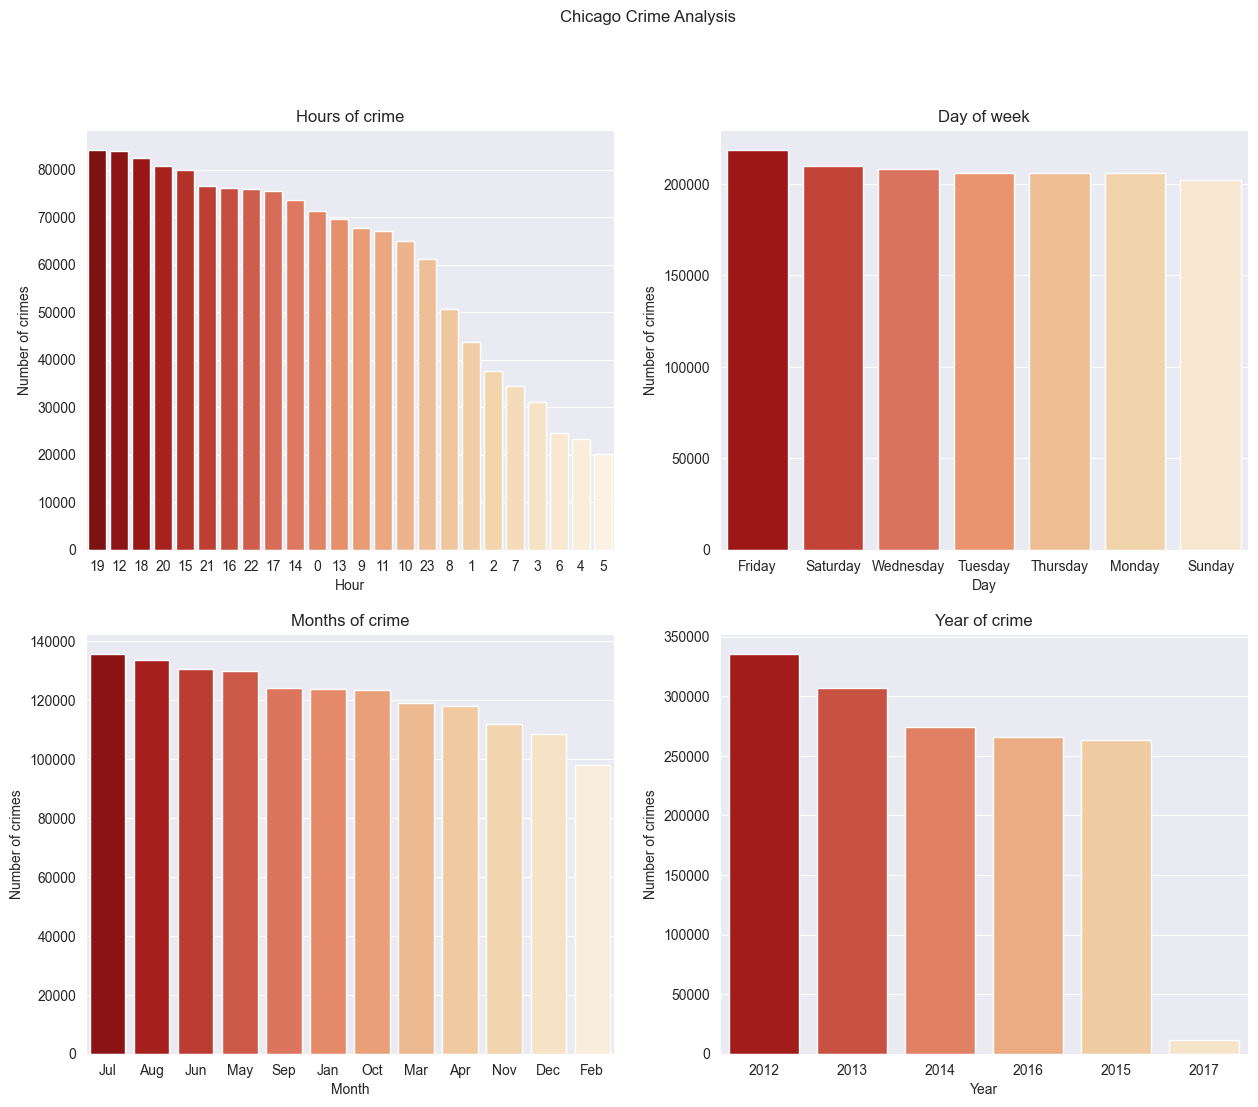

In [60]:
import calendar

df_hours = df.groupby([df.index.hour]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by hours
df_week = df.groupby([df.index.day_name()]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by day of the week
df_month = df.groupby([df.index.month]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by month
df_year = df.groupby([df.index.year]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by year


df_month = df_month.reset_index()
df_month['Date'] = df_month['Date'].apply(lambda x: calendar.month_abbr[x]) #Convert number representation of month (8) to string (August)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0]) #Bar plot visualizations
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(data=df_month, x='Date', y='ID', palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Hours of crime')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Day of week')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Months of crime')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Year of crime')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Chicago Crime Analysis') #Main title
plt.show()

##### The above EDA suggests that most crimes in Chicago from 2012 - 2017 took place at 12pm and between 6pm-8pm , with most crimes occurring on Fridays. The data suggests that most crimes in Chicago took place in July and August, and that over the years, crime gradually decreased. 2017 has a particularly low crime rate; this is because 18th January 2017 is the last recorded date for this particular dataset.

#### Analysis of crimes

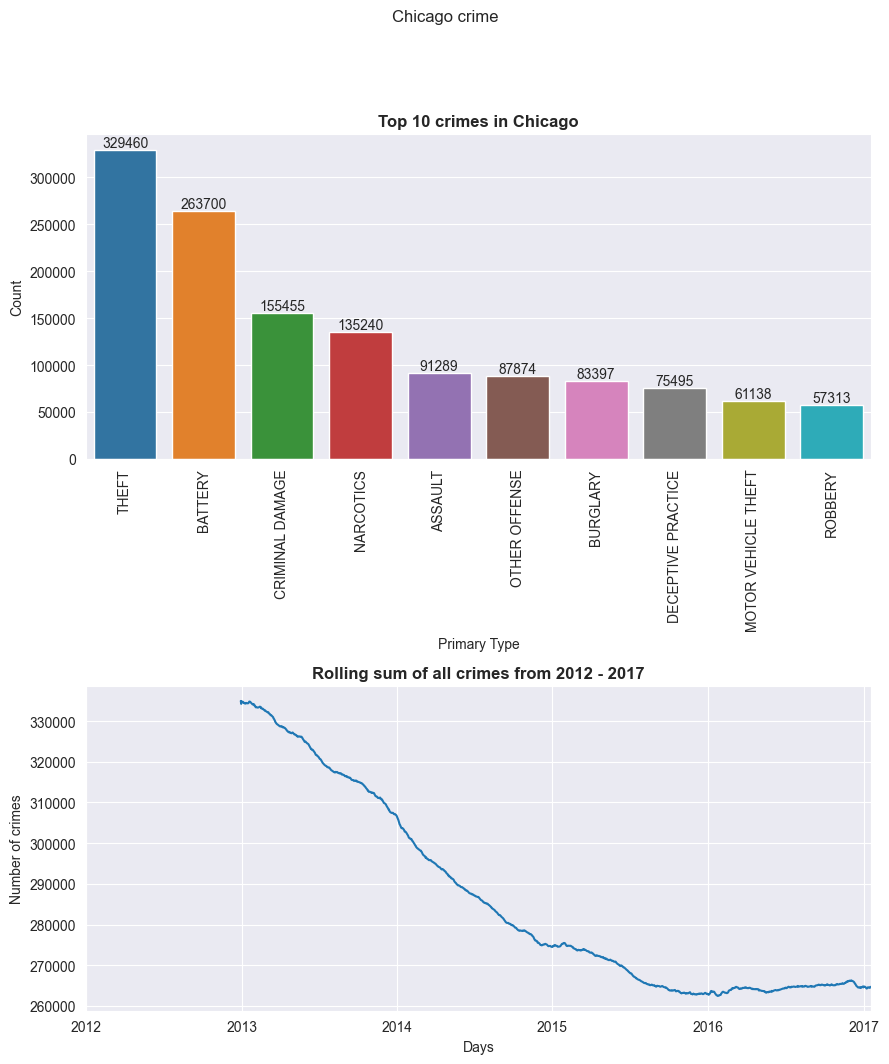

In [61]:
fig, axs = plt.subplots(2, figsize=(9, 10))
topcrimes = df['Primary Type'].value_counts()[:10] #Get top 10 occuring crimes

ax = sns.barplot(x=topcrimes.index, y=topcrimes.values, ax=axs[0])
ax1 = df.resample('D').size().rolling(365).sum().plot(ax=axs[1]) #Rolling sum

for i in ax.containers:
    ax.bar_label(i,) #Add value at the top of each bar

ax.set_xlabel('Primary Type')
ax.set_ylabel('Count')
ax.set_title('Top 10 crimes in Chicago', weight='bold')
ax.set_xticks(range(0,len(topcrimes.index)), topcrimes.index, rotation=90) #Rotate by 90 degrees

ax1.set_xlabel('Days')
ax1.set_ylabel('Number of crimes')
ax1.set_title('Rolling sum of all crimes from 2012 - 2017', weight='bold')

fig.suptitle("Chicago crime", y=1.06) #Main title
plt.tight_layout()
plt.show()

##### The above graph suggests that theft, battery, and criminal damage are the three most common crimes in Chicago. The rolling sum plot also suggests that crime in Chicago is gradually decreasing throughout the years.

#### Crime counts according to whether arrests were made or not

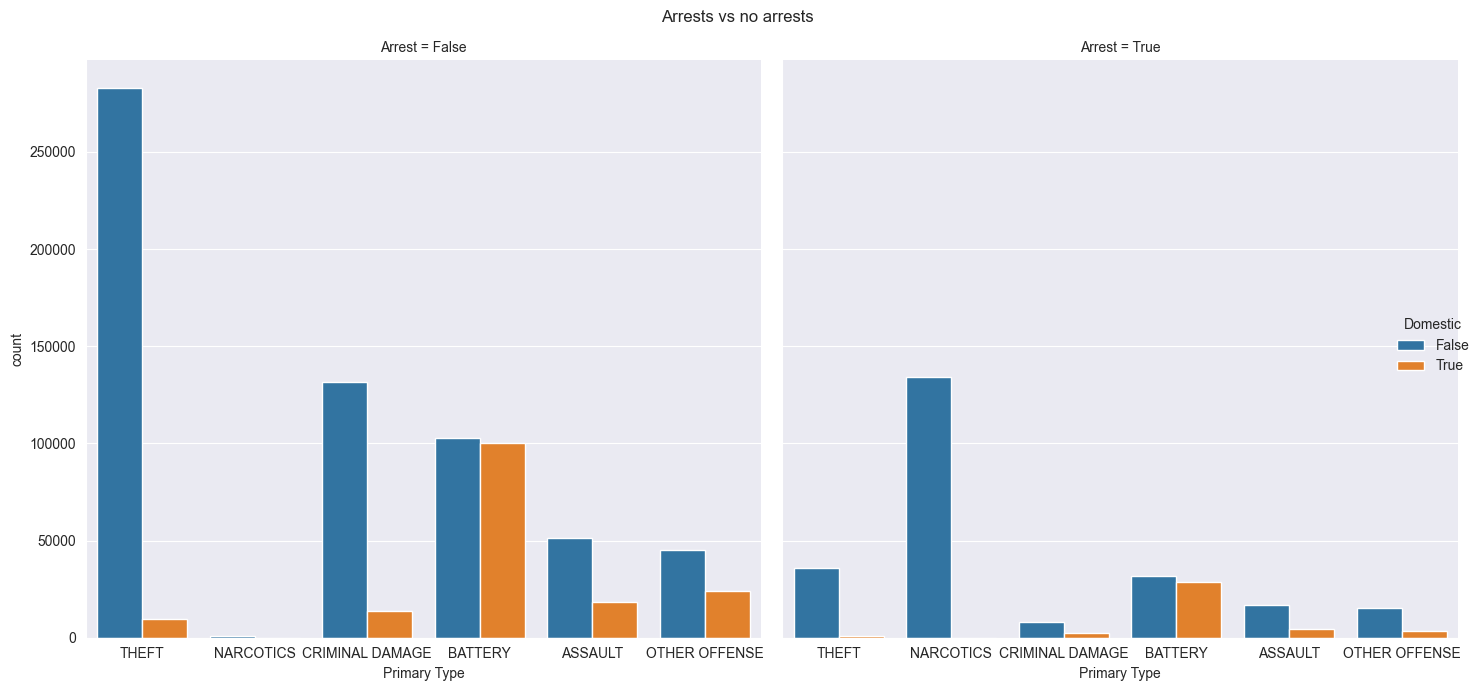

In [62]:
topcrimes = df['Primary Type'].value_counts()[:6] #Get top 6 crimes
df_grouped = df.loc[df['Primary Type'].isin(topcrimes.index)].groupby(['Arrest', 'Domestic', 'Primary Type']).size().reset_index(name='count').sort_values('count', ascending=False) #Arrest vs no arrests according to domestic crimes
sns.catplot(df_grouped, x='Primary Type', y='count', hue='Domestic', kind='bar', col='Arrest', height=7) #Plot using FacetGrid/catplot

plt.suptitle('Arrests vs no arrests') #Main title
plt.tight_layout()
plt.show()

##### The above categorical plot suggests that in Chicago from 2012-2017, most crimes that lead to no arrest were thefts, and most crimes that led to arrests were narcotics. Most domestic-related crimes were linked to battery and assault.

#### Yearly crime count trends according to number of arrests made

In [63]:
# plt.figure(figsize=(10,8))
# df_day_noarrest = df.loc[~df['Arrest']].resample('M').size().to_frame(name='count')
# df_day_arrest = df.loc[df['Arrest']].resample('M').size().to_frame(name='count')

# df_day_noarrest['Arrest'] = False
# df_day_arrest['Arrest'] = True

# df_merge = pd.concat([df_day_noarrest, df_day_arrest])

# sns.lineplot(df_merge, x=df_merge.index, y='count', hue='Arrest')

# plt.xlabel('Date')
# plt.ylabel('Count')
# plt.title('Chicago yearly crime trend', weight='bold')
# plt.show()

#### Brief overview of Chicago crime trends according to the top 6 crimes

Text(0.5, 1.05, 'Chicago crimes')

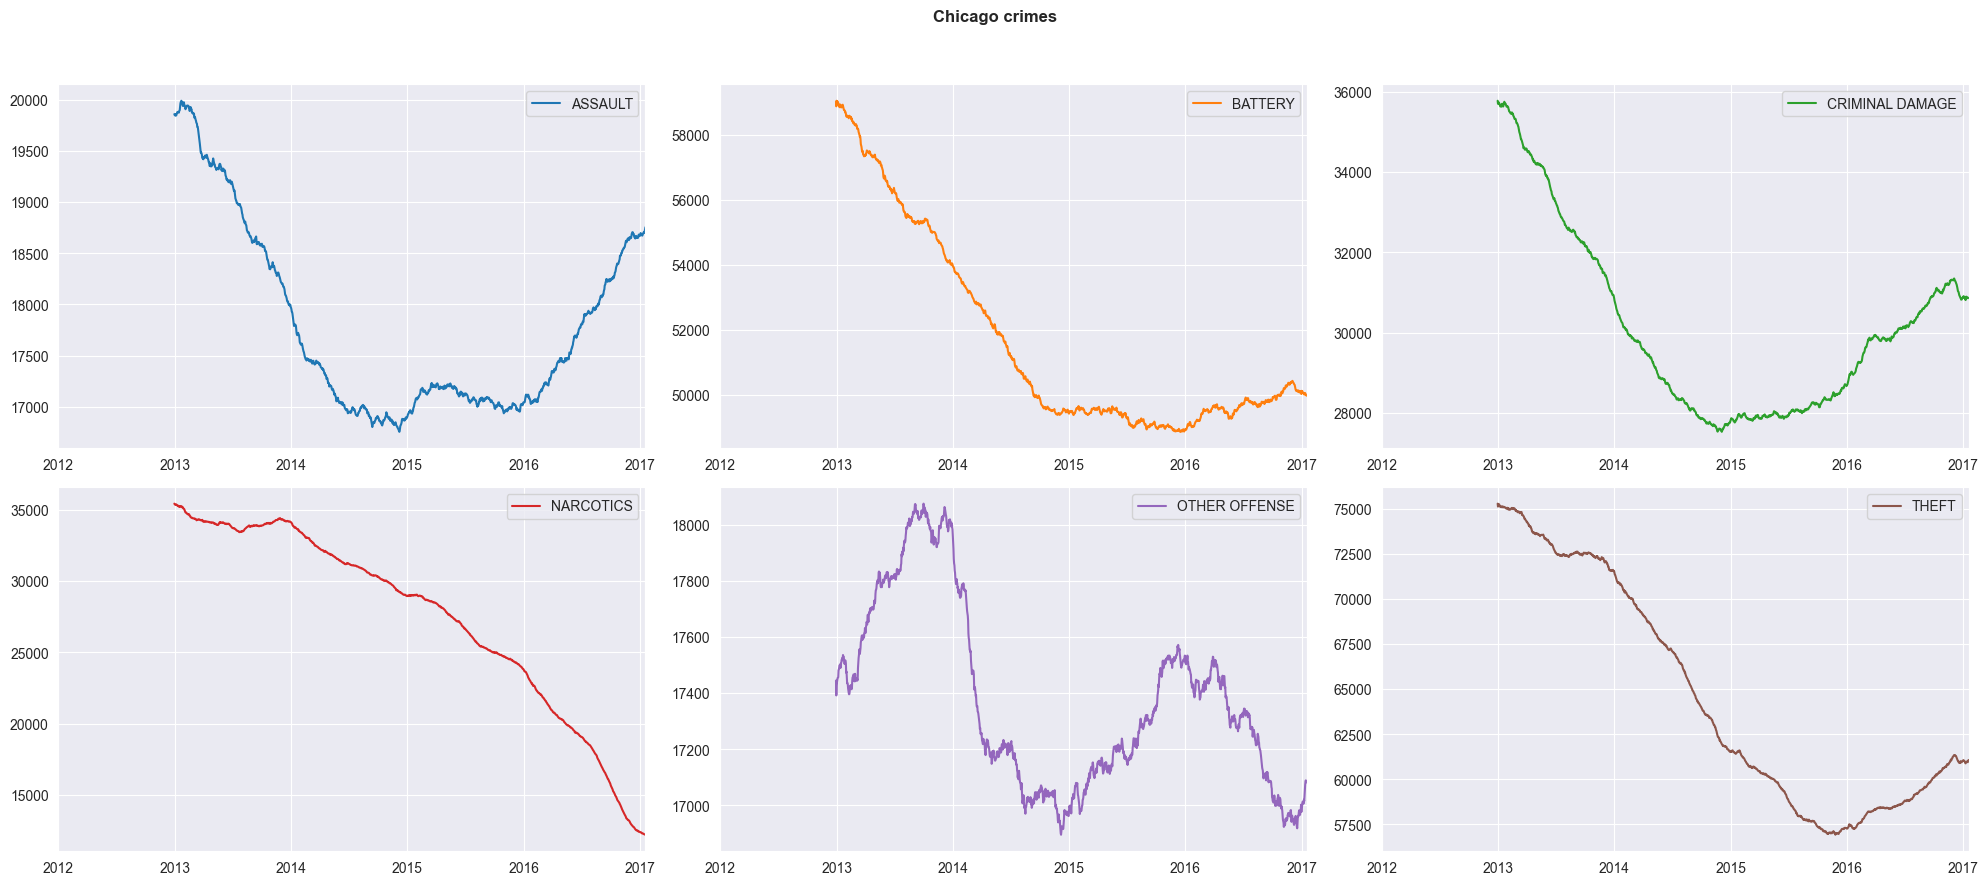

In [64]:
topcrimes = df['Primary Type'].value_counts()[:6] #Get top 6 crimes

topcrimes = df.loc[df['Primary Type'].isin(topcrimes.index.to_numpy())] #All crimes that fall under the top 6 crimes
pivot = topcrimes.pivot_table('ID', aggfunc=np.size, index=topcrimes.index.date, columns='Primary Type') #Create pivot table
pivot.index = pd.DatetimeIndex(pivot.index)
pivot.rolling(365).sum().plot(figsize=(20, 12), sharex=False, sharey=False, subplots=True, layout=(3, 3)) #Rolling sum plot of each 6 crimes over the years

plt.tight_layout()
plt.suptitle("Chicago crimes", y=1.05, weight='bold') #Main title

##### This EDA suggests that narcotic, battery, and theft-related crimes have drastically decreased over the years, whereas assaults and criminal damage related crimes have dipped and are rapidly increasing again.

#### Interactive heatmap of crimes in Chicago

In [110]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
heatmap = df.copy()
#heatmap["Latitude"] = to_bin(df[(df["Latitude"] == 41.80)]['Latitude'])
#heatmap["Longitude"] = to_bin(df[(df["Longitude"] == -87.78)]['Longitude'])
heatmap = heatmap.groupby(["Latitude", "Longitude", "Block"]).count()['ID'].reset_index(name='Count')

#heatmap = heatmap[(heatmap["Latitude"] != 41.80) & (heatmap["Longitude"] != -87.78)] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

In [111]:
heatmap

,Latitude,Longitude,Block,Count
0,36.619446,-91.686566,004XX E LOWER WACKER DR,2
1,36.619446,-91.686566,016XX W 80TH ST,1
2,36.619446,-91.686566,017XX W 80TH ST,2
3,36.619446,-91.686566,019XX S CANALPORT AVE,1
4,36.619446,-91.686566,020XX W NORTH AVE,10
...,...,...,...,...
384302,42.022554,-87.666236,077XX N SHERIDAN RD,1
384303,42.022575,-87.666158,077XX N SHERIDAN RD,1
384304,42.022586,-87.666121,077XX N SHERIDAN RD,1
384305,42.022671,-87.677132,077XX N CLARK ST,2


In [23]:
fig = px.scatter_mapbox(heatmap, lat="Latitude", lon="Longitude",
                    zoom=9.7, height=700, size_max=30, color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'],color="Count", hover_data=["Count"], size='Count', hover_name="Block")
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Static heatmap of Chicago crime hotspots

##### Create geodataframe

In [161]:
heatmap = heatmap.sort_values('Count', ascending=False)[:5].drop_duplicates(['Block'])
heatmap['Size'] = heatmap['Count'] / 15
geo_df = gpd.GeoDataFrame(heatmap, geometry=[Point(xy) for xy in zip(heatmap['Longitude'], heatmap['Latitude'])])

##### Plot

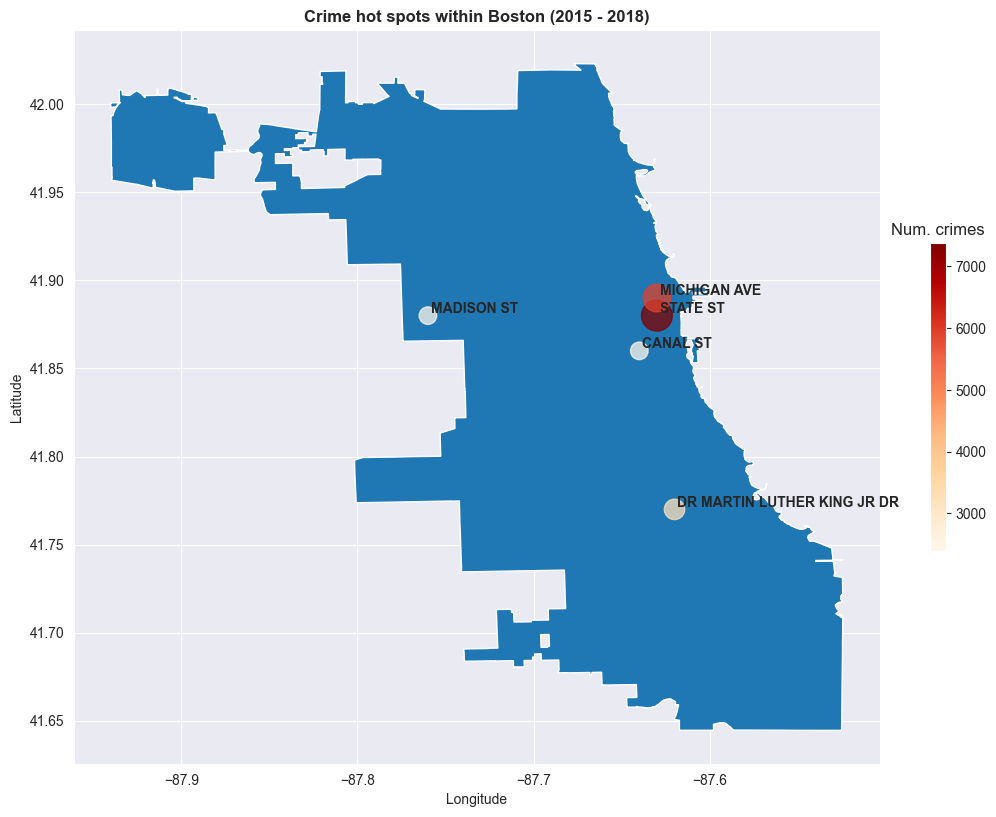

In [162]:
fig, ax = plt.subplots(figsize=(13,10))
map = gpd.read_file("chicago/chicago.shp")
map.plot(ax=ax, aspect=1)
geo_df.plot(aspect=1, column='Count', ax=ax, cmap='OrRd', markersize='Size', legend=True, alpha=0.75, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same SA map.

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Block']):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points", weight='bold')

ax.get_figure().get_axes()[1].set_title("Num. crimes")
plt.title('Crime hot spots within Boston (2015 - 2018)', weight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [160]:
heatmap.sort_values('Count', ascending=False)
geo_df


,Latitude,Longitude,Block,Count,Size,geometry
7751,41.88,-87.63,STATE ST,7380,492.000000,POINT (-87.63000 41.88000)
8137,41.89,-87.63,MICHIGAN AVE,5920,394.666667,POINT (-87.63000 41.89000)
3220,41.77,-87.62,DR MARTIN LUTHER KING JR DR,3226,215.066667,POINT (-87.62000 41.77000)
7003,41.86,-87.64,CANAL ST,2404,160.266667,POINT (-87.64000 41.86000)
7431,41.88,-87.76,MADISON ST,2392,159.466667,POINT (-87.76000 41.88000)
10908,41.97,-87.91,TERMINAL ST,2341,156.066667,POINT (-87.91000 41.97000)
2306,41.75,-87.75,CICERO AVE,2235,149.000000,POINT (-87.75000 41.75000)
10050,41.94,-87.66,CLARK ST,2230,148.666667,POINT (-87.66000 41.94000)
10092,41.94,-87.65,HALSTED ST,2122,141.466667,POINT (-87.65000 41.94000)


### <u>Machine Learning</u>

#### Import

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier

#### Data aquisition

In [20]:
X = df.drop(['Arrest'], axis=1)
y = df['Arrest']

le = LabelEncoder()
y = le.fit_transform(y)

#### Sampling/split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Algorithm training

In [22]:
def modelEvaluation(clf, encoder, scoring):
    cv = KFold(n_splits=5)
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"])
    for i in range(len(clf)):  
        start = process_time()  
        name = clf[i].__class__.__name__
        model = make_pipeline(encoder[i], StandardScaler(), clf[i]) if name == 'KNeighborsClassifier' else make_pipeline(encoder[i], clf[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        avg = round(cv_score.mean()*100, 2)
        std = round(cv_score.std()*100,2)
        accuracy = round(accuracy_score(y_test, y_pred)*100,2)
        precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
        recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
        f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
        print(f"{name} {avg}% std: {std}")
        print(f"{name} accuracy score: {accuracy}%")
        end = process_time()
        print(f"Time taken: {end-start}s\n")
        results = pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})])
        #print(np.unique(y_pred))

    return results.reset_index(drop=True)
  
clf = [RandomForestClassifier(n_jobs=-1, random_state=42),
       DecisionTreeClassifier(random_state=42),
       CatBoostClassifier(random_state=42, silent=True, allow_writing_files=False),
       AdaBoostClassifier(random_state=42),
       GaussianNB(),
       KNeighborsClassifier()
       ]
encoders = [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ]

#### Cross Validation & Results

In [23]:
d = modelEvaluation(clf, encoders, 'f1_weighted')

RandomForestClassifier 84.53% std: 0.32
RandomForestClassifier accuracy score: 84.67%
Time taken: 610.546875s

DecisionTreeClassifier 71.1% std: 1.97
DecisionTreeClassifier accuracy score: 69.38%
Time taken: 19.1875s

CatBoostClassifier 86.49% std: 0.14
CatBoostClassifier accuracy score: 86.93%
Time taken: 55.125s

AdaBoostClassifier 83.28% std: 0.69
AdaBoostClassifier accuracy score: 85.39%
Time taken: 82.5s



c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



GaussianNB 63.06% std: 0.11
GaussianNB accuracy score: 74.08%
Time taken: 7.296875s

KNeighborsClassifier 82.72% std: 0.08
KNeighborsClassifier accuracy score: 83.49%
Time taken: 74.3125s



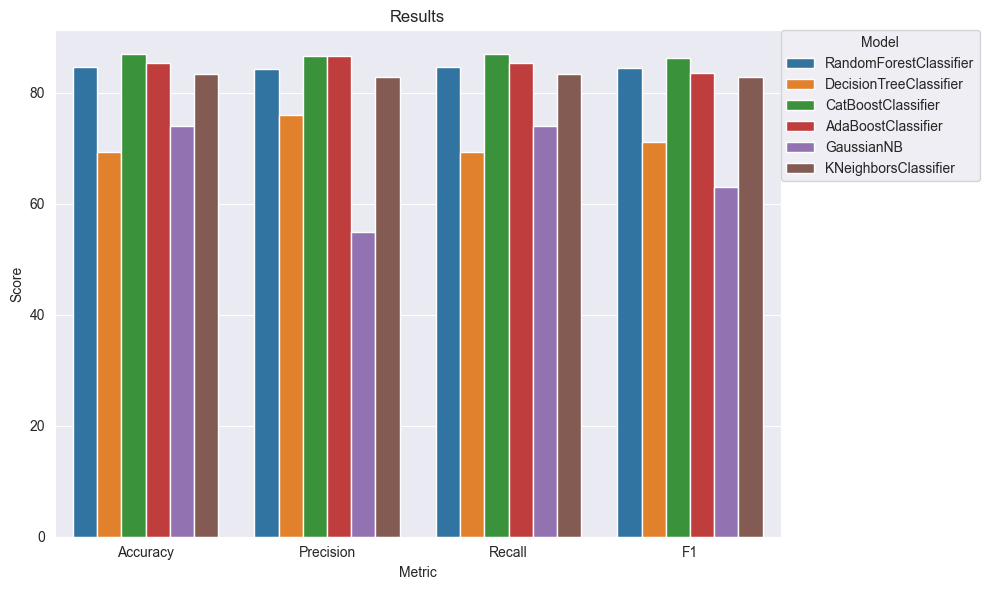

In [24]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score (%)")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

## <center><b>Thanks for reading!</b>